# Dynamic Pricing EDA

In [1]:
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import plotly.express as px

In [2]:
# Extract the ZIP file
zip_file_path = 'Dynamic Pricing.zip'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('dynamic_pricing_data')

# Load the dataset
csv_file_path = 'dynamic_pricing_data/dynamic_pricing.csv'
data = pd.read_csv(csv_file_path)

# Display the first few rows of the dataset
print("Dataset Overview:")
print(data.head())

# Dataset Information
print("\nDataset Info:")
print(data.info())
print("\nMissing Values:")
print(data.isnull().sum())

# Summary Statistics
print("\nSummary Statistics:")
print(data.describe())


Dataset Overview:
   Number_of_Riders  Number_of_Drivers Location_Category  \
0                90                 45             Urban   
1                58                 39          Suburban   
2                42                 31             Rural   
3                89                 28             Rural   
4                78                 22             Rural   

  Customer_Loyalty_Status  Number_of_Past_Rides  Average_Ratings  \
0                  Silver                    13             4.47   
1                  Silver                    72             4.06   
2                  Silver                     0             3.99   
3                 Regular                    67             4.31   
4                 Regular                    74             3.77   

  Time_of_Booking Vehicle_Type  Expected_Ride_Duration  \
0           Night      Premium                      90   
1         Evening      Economy                      43   
2       Afternoon      Premium        

In [3]:
duplicate_rows = data.duplicated()
print(f"Number of Duplicate Rows: {duplicate_rows.sum()}")
print(data['Location_Category'].unique())
print(data['Customer_Loyalty_Status'].unique())
print(data['Vehicle_Type'].unique())
print(data['Time_of_Booking'].unique())


Number of Duplicate Rows: 0
['Urban' 'Suburban' 'Rural']
['Silver' 'Regular' 'Gold']
['Premium' 'Economy']
['Night' 'Evening' 'Afternoon' 'Morning']


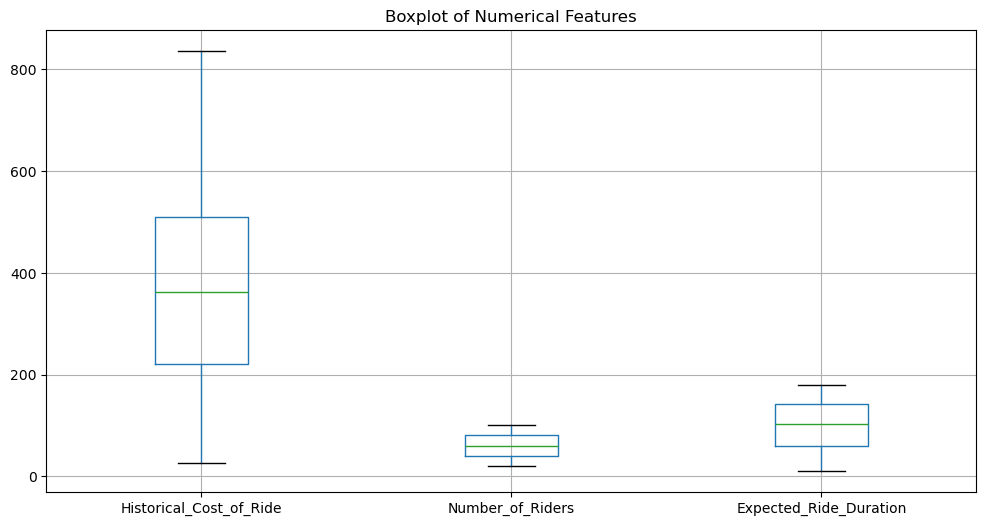

In [4]:
data[['Historical_Cost_of_Ride', 'Number_of_Riders', 'Expected_Ride_Duration']].boxplot(figsize=(12, 6))
plt.title("Boxplot of Numerical Features")
plt.show()


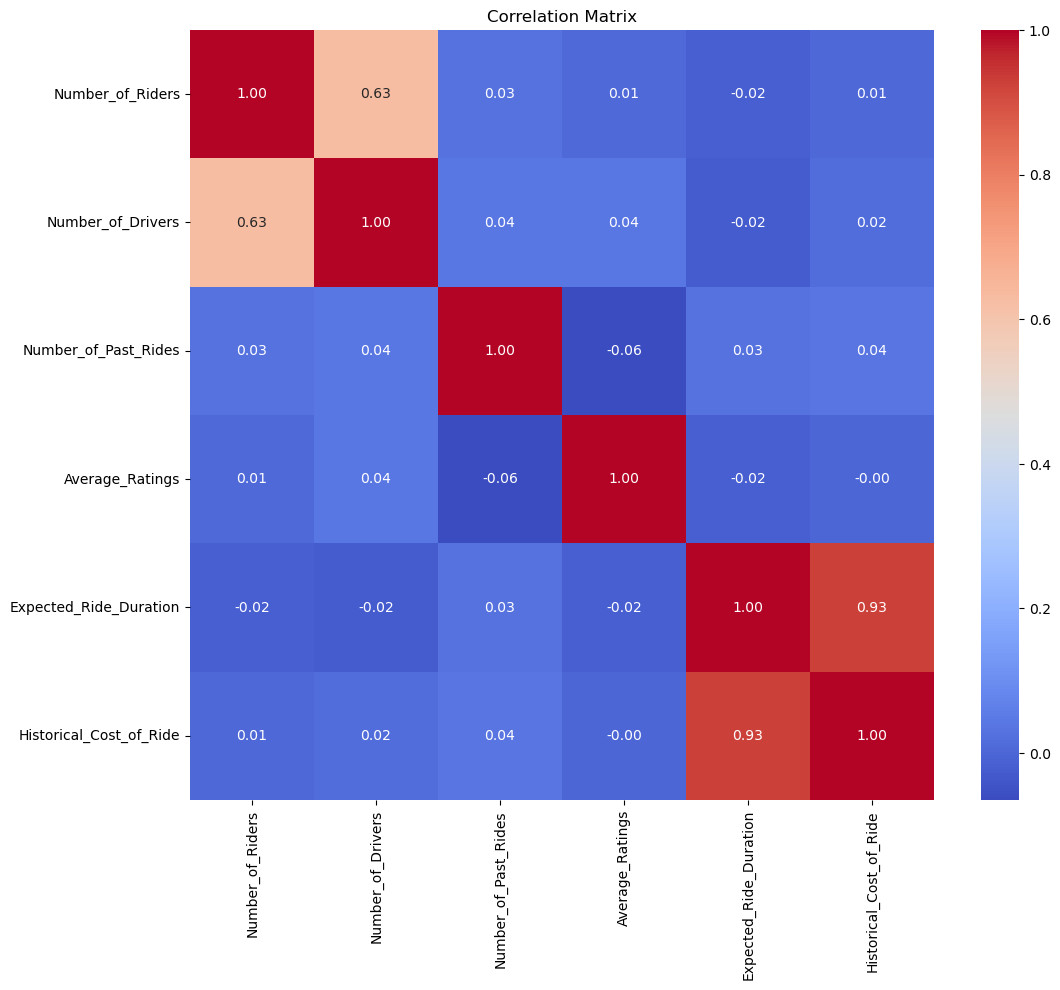

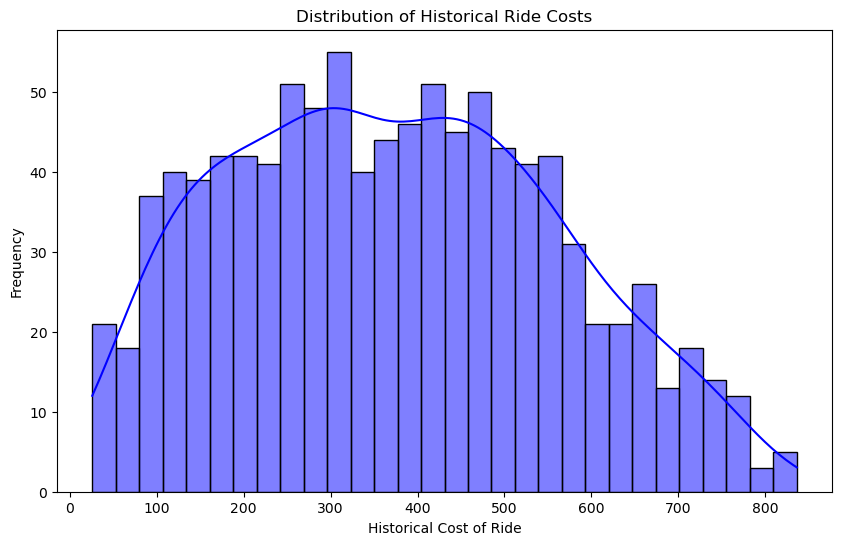

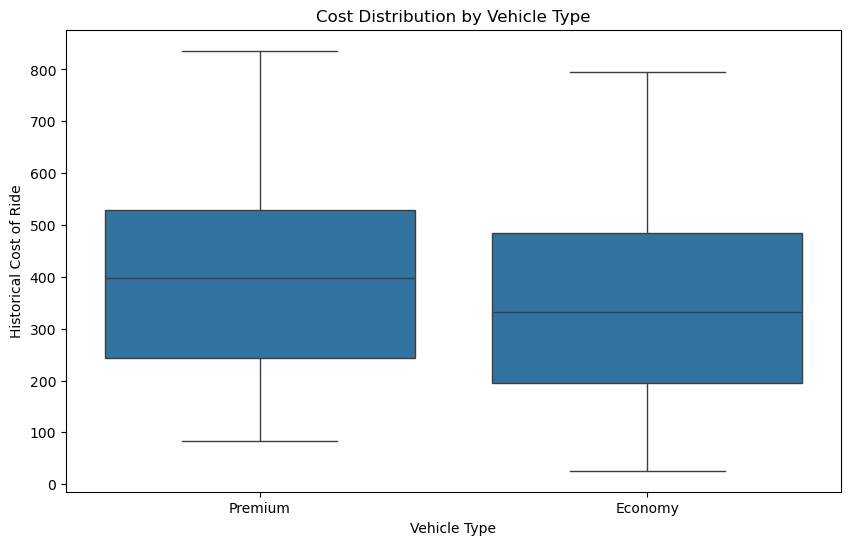

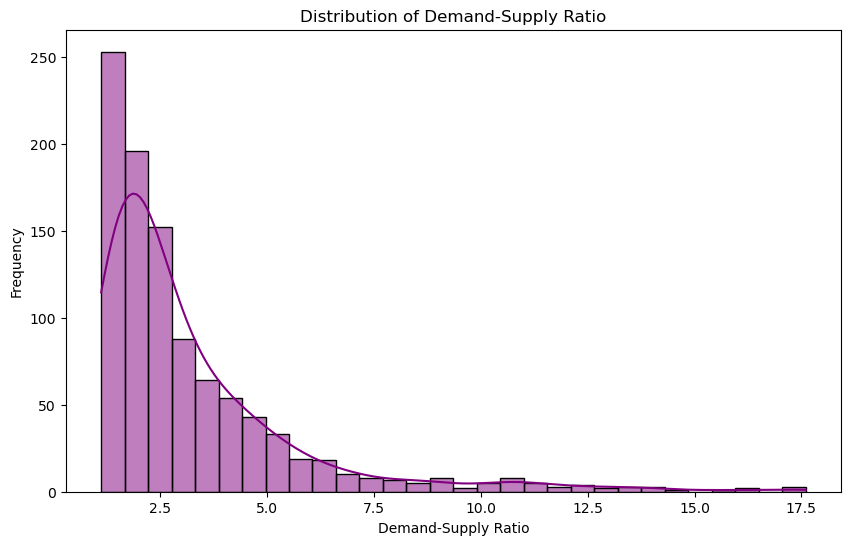

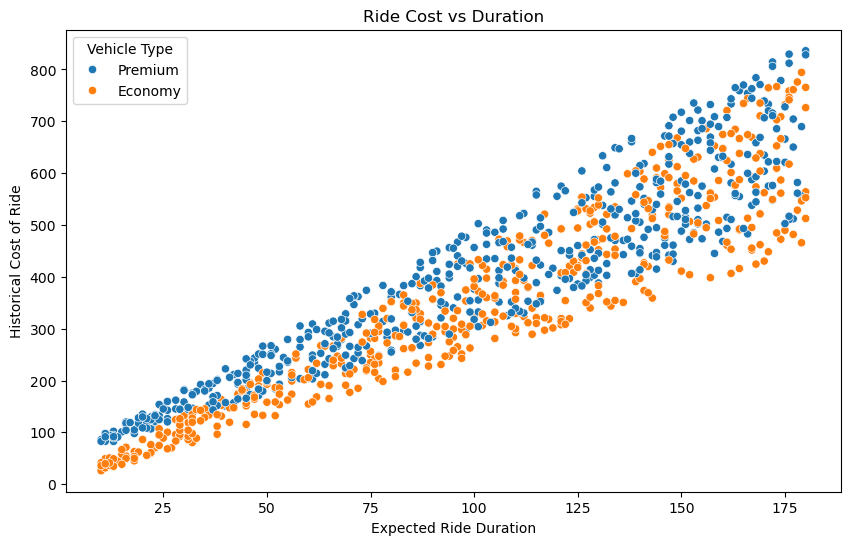

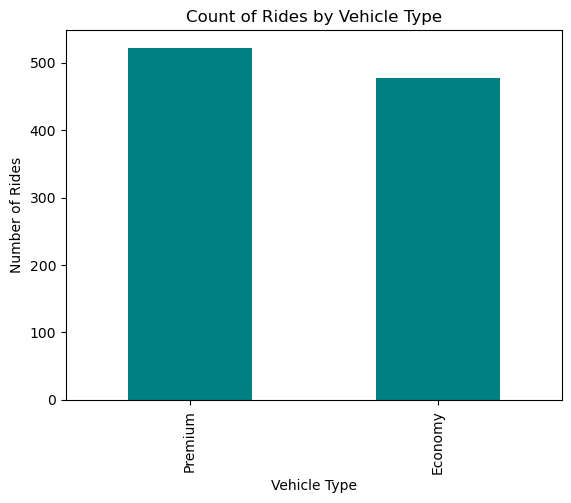

In [5]:
# Filter numeric columns only
numeric_data = data.select_dtypes(include=[np.number])

# Correlation Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()

# Distribution of Historical Cost
plt.figure(figsize=(10, 6))
sns.histplot(data['Historical_Cost_of_Ride'], bins=30, kde=True, color='blue')
plt.title("Distribution of Historical Ride Costs")
plt.xlabel("Historical Cost of Ride")
plt.ylabel("Frequency")
plt.show()

# Average Cost by Vehicle Type
plt.figure(figsize=(10, 6))
sns.boxplot(x='Vehicle_Type', y='Historical_Cost_of_Ride', data=data)
plt.title("Cost Distribution by Vehicle Type")
plt.xlabel("Vehicle Type")
plt.ylabel("Historical Cost of Ride")
plt.show()

data['Demand_Supply_Ratio'] = data['Number_of_Riders'] / data['Number_of_Drivers']
plt.figure(figsize=(10, 6))
sns.histplot(data['Demand_Supply_Ratio'], bins=30, kde=True, color='purple')
plt.title("Distribution of Demand-Supply Ratio")
plt.xlabel("Demand-Supply Ratio")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Expected_Ride_Duration', y='Historical_Cost_of_Ride', hue='Vehicle_Type', data=data)
plt.title("Ride Cost vs Duration")
plt.xlabel("Expected Ride Duration")
plt.ylabel("Historical Cost of Ride")
plt.legend(title='Vehicle Type')
plt.show()

data['Vehicle_Type'].value_counts().plot(kind='bar', color='teal')
plt.title("Count of Rides by Vehicle Type")
plt.xlabel("Vehicle Type")
plt.ylabel("Number of Rides")
plt.show()


In [7]:
# Feature Engineering

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

# One-Hot Encoding for Categorical Features
categorical_features = ['Location_Category', 'Customer_Loyalty_Status', 'Vehicle_Type', 'Time_of_Booking']
encoded_data = pd.get_dummies(data[categorical_features])

# Combine Encoded Features
data = pd.concat([data, encoded_data], axis=1)

# Scale Numerical Features
numerical_features = ['Number_of_Riders', 'Number_of_Drivers', 'Number_of_Past_Rides', 
                      'Average_Ratings', 'Expected_Ride_Duration']
scaler = MinMaxScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

# Drop Original Categorical Columns
data.drop(columns=categorical_features, inplace=True)


In [8]:
print("Encoded Columns:", encoded_data.columns)
print("Dataset Info After Feature Engineering:")
print(data.info())

Encoded Columns: Index(['Location_Category_Rural', 'Location_Category_Suburban',
       'Location_Category_Urban', 'Customer_Loyalty_Status_Gold',
       'Customer_Loyalty_Status_Regular', 'Customer_Loyalty_Status_Silver',
       'Vehicle_Type_Economy', 'Vehicle_Type_Premium',
       'Time_of_Booking_Afternoon', 'Time_of_Booking_Evening',
       'Time_of_Booking_Morning', 'Time_of_Booking_Night'],
      dtype='object')
Dataset Info After Feature Engineering:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Number_of_Riders                 1000 non-null   float64
 1   Number_of_Drivers                1000 non-null   float64
 2   Number_of_Past_Rides             1000 non-null   float64
 3   Average_Ratings                  1000 non-null   float64
 4   Expected_Ride_Duration           1000 non-null   float

In [9]:
# Rule-Based Pricing System

def base_price(duration):
    if duration <= 10:
        return 5
    elif 10 < duration <= 30:
        return 10
    elif 30 < duration <= 60:
        return 15
    else:
        return 25

# Apply Base Pricing Rule
data['Base_Price'] = data['Expected_Ride_Duration'].apply(base_price)
print(data[['Expected_Ride_Duration', 'Base_Price']].head())


   Expected_Ride_Duration  Base_Price
0                0.470588           5
1                0.194118           5
2                0.388235           5
3                0.729412           5
4                0.817647           5


In [10]:
# Introduce Fuzzy Logic for Price Adjustment

# Fuzzy variables
demand = ctrl.Antecedent(np.arange(0, 11, 1), 'demand')
supply = ctrl.Antecedent(np.arange(0, 11, 1), 'supply')
price_adjustment = ctrl.Consequent(np.arange(-5, 6, 1), 'price_adjustment')

# Membership functions
demand.automf(3)  # Low, Medium, High
supply.automf(3)  # Low, Medium, High
price_adjustment['decrease'] = fuzz.trimf(price_adjustment.universe, [-5, -5, 0])
price_adjustment['no_change'] = fuzz.trimf(price_adjustment.universe, [-2, 0, 2])
price_adjustment['increase'] = fuzz.trimf(price_adjustment.universe, [0, 5, 5])

# Fuzzy rules
rule1 = ctrl.Rule(demand['poor'] & supply['good'], price_adjustment['decrease'])
rule2 = ctrl.Rule(demand['average'] & supply['average'], price_adjustment['no_change'])
rule3 = ctrl.Rule(demand['good'] & supply['poor'], price_adjustment['increase'])

# Control system
pricing_ctrl = ctrl.ControlSystem([rule1, rule2, rule3])
pricing_sim = ctrl.ControlSystemSimulation(pricing_ctrl)

# Example adjustment
pricing_sim.input['demand'] = 8  # High demand
pricing_sim.input['supply'] = 3  # Low supply
pricing_sim.compute()
print(f"Price Adjustment: {pricing_sim.output['price_adjustment']:.2f}")


Price Adjustment: 1.70


In [11]:
# Predictive Modeling for Dynamic Pricing

# Prepare Features and Target
X = data.drop(columns=['Historical_Cost_of_Ride'])
y = data['Historical_Cost_of_Ride']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate the Model
y_pred = rf_model.predict(X_test)
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred):.2f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"R² Score: {r2_score(y_test, y_pred):.2f}")


Mean Squared Error: 5567.15
Mean Absolute Error: 55.78
R² Score: 0.85


In [12]:
# Dynamic Pricing Simulation

# Simulate Pricing
simulated_demand = [8, 6, 9]  # Example demand levels
simulated_supply = [2, 5, 3]  # Example supply levels
adjusted_prices = []

for d, s in zip(simulated_demand, simulated_supply):
    pricing_sim.input['demand'] = d
    pricing_sim.input['supply'] = s
    pricing_sim.compute()
    adjustment = pricing_sim.output['price_adjustment']
    base_price = 10  # Example base price
    adjusted_prices.append(base_price + adjustment)

print(f"Simulated Adjusted Prices: {adjusted_prices}")


Simulated Adjusted Prices: [12.020382165605096, 10.0, 12.155987055016181]


In [ ]:
# Next Steps
# Feature Engineering: Add temporal patterns (e.g., peak hours, holidays).
# Model Refinement: Experiment with Gradient Boosting or Neural Networks.
# Deploy: Use Flask or FastAPI to create an API for real-time pricing.

<Figure size 1200x1000 with 0 Axes>

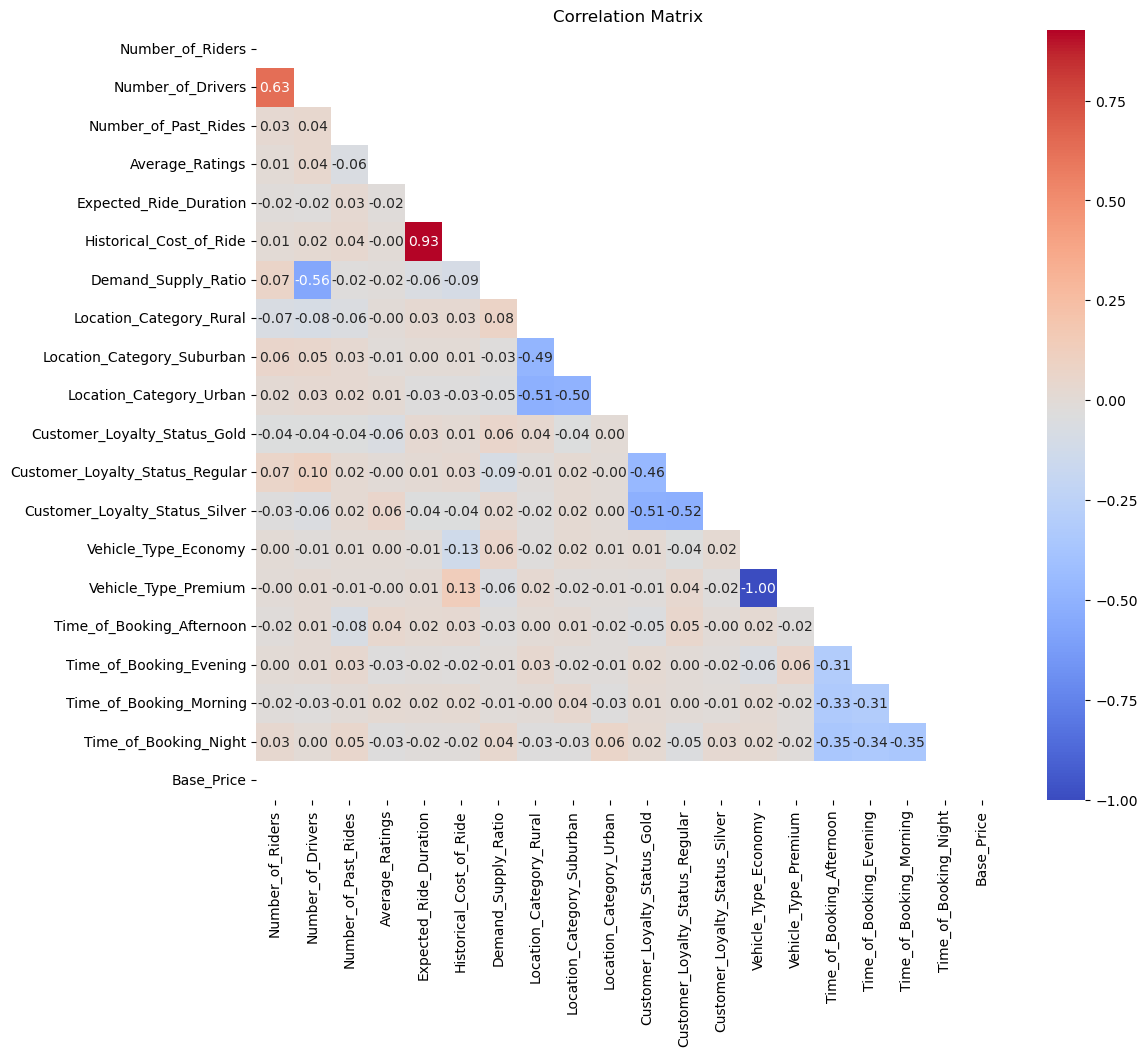

In [13]:
# Correlation Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f', mask=np.triu(data.corr()))
plt.title("Correlation Matrix")
plt.show()


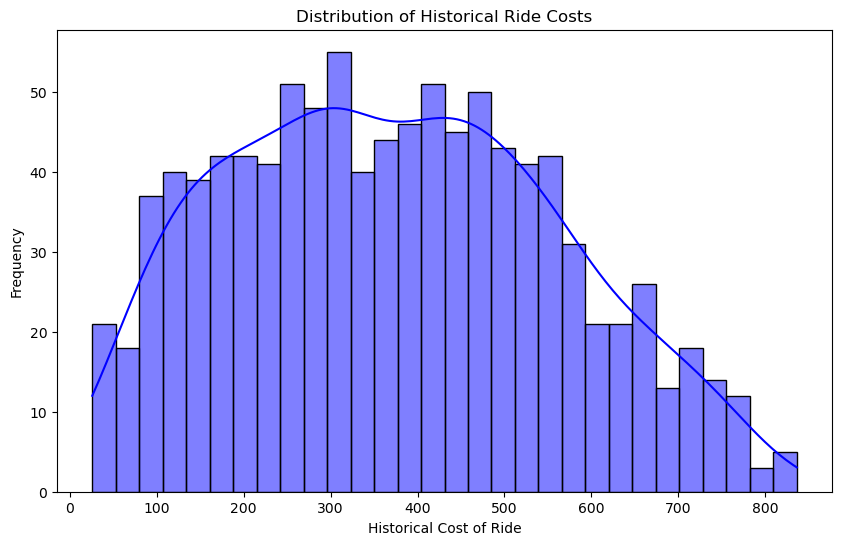

In [14]:
# Distribution of Historical Costs
plt.figure(figsize=(10, 6))
sns.histplot(data['Historical_Cost_of_Ride'], bins=30, kde=True, color='blue')
plt.title("Distribution of Historical Ride Costs")
plt.xlabel("Historical Cost of Ride")
plt.ylabel("Frequency")
plt.show()


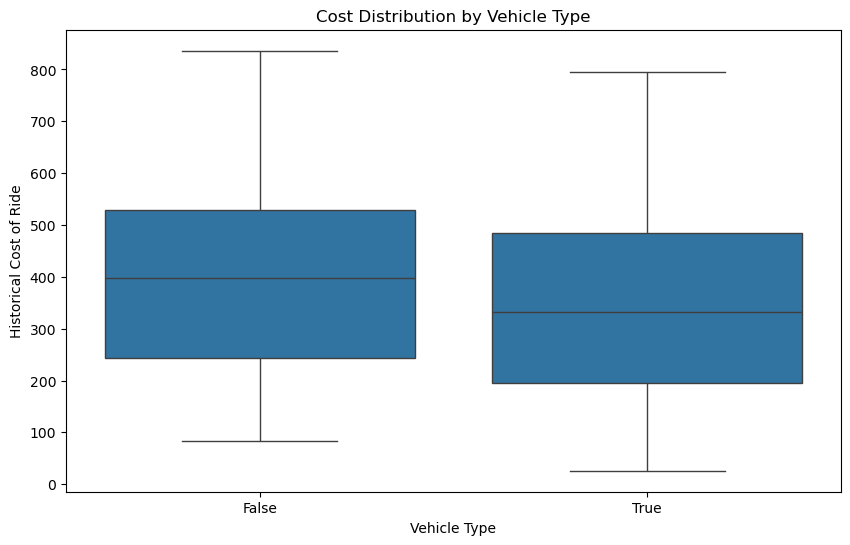

In [15]:
# Cost by Vehicle Type
plt.figure(figsize=(10, 6))
sns.boxplot(x='Vehicle_Type_Economy', y='Historical_Cost_of_Ride', data=data)
plt.title("Cost Distribution by Vehicle Type")
plt.xlabel("Vehicle Type")
plt.ylabel("Historical Cost of Ride")
plt.show()


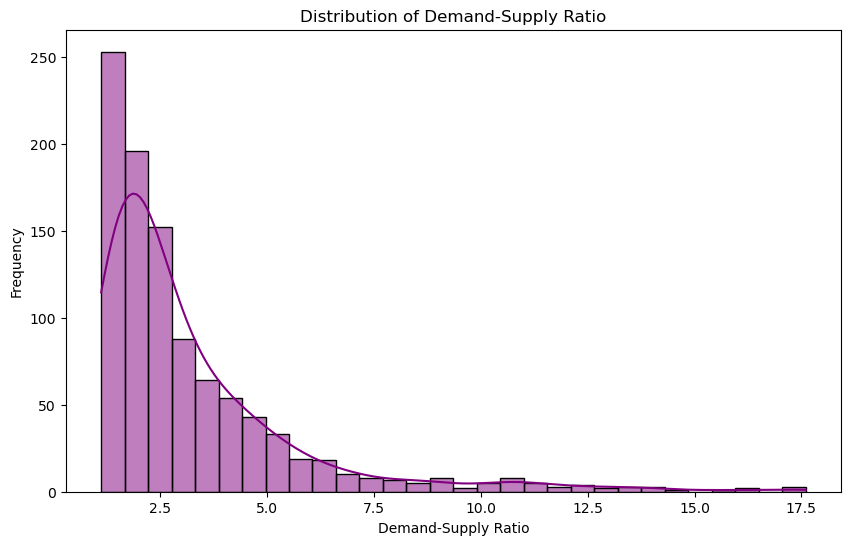

In [16]:
# Distribution of Demand-Supply Ratio
plt.figure(figsize=(10, 6))
sns.histplot(data['Demand_Supply_Ratio'], bins=30, kde=True, color='purple')
plt.title("Distribution of Demand-Supply Ratio")
plt.xlabel("Demand-Supply Ratio")
plt.ylabel("Frequency")
plt.show()


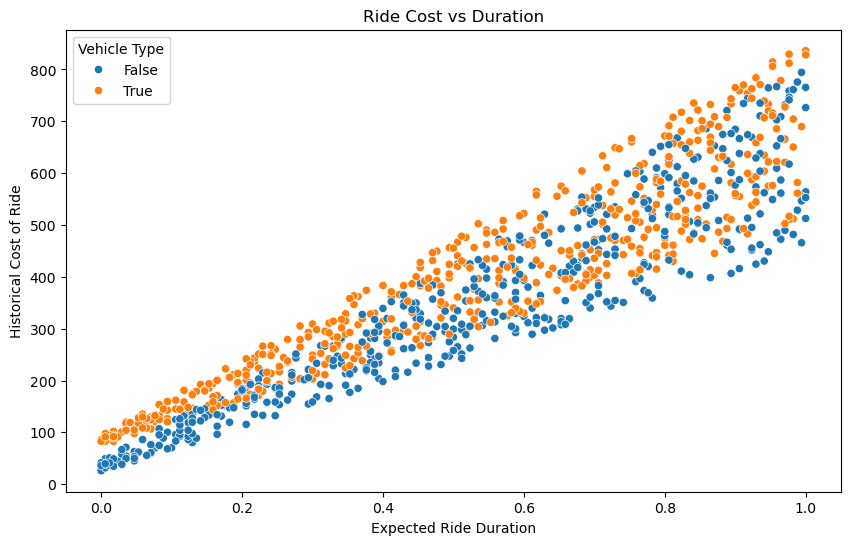

In [17]:
# Ride Cost vs. Duration
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Expected_Ride_Duration', y='Historical_Cost_of_Ride', hue='Vehicle_Type_Premium', data=data)
plt.title("Ride Cost vs Duration")
plt.xlabel("Expected Ride Duration")
plt.ylabel("Historical Cost of Ride")
plt.legend(title='Vehicle Type')
plt.show()


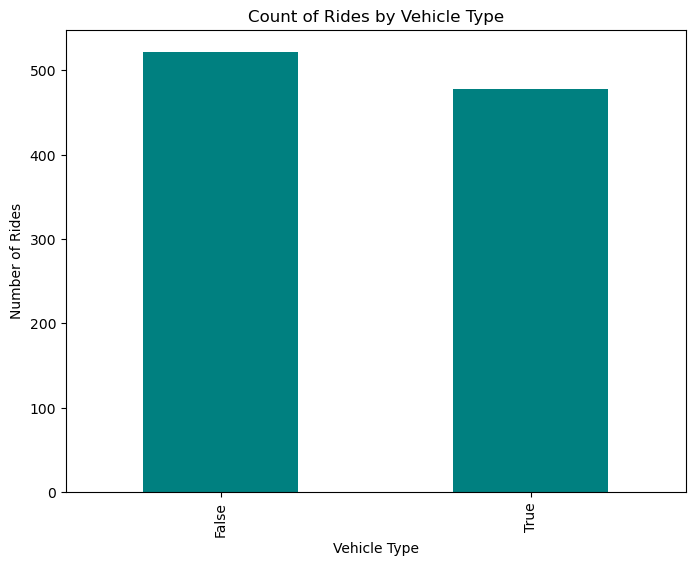

In [18]:
# Count of Rides by Vehicle Type
plt.figure(figsize=(8, 6))
data['Vehicle_Type_Economy'].value_counts().plot(kind='bar', color='teal')
plt.title("Count of Rides by Vehicle Type")
plt.xlabel("Vehicle Type")
plt.ylabel("Number of Rides")
plt.show()


C:\Users\milto\AppData\Local\Temp\ipykernel_14792\1658036287.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Time_of_Booking_Night', y='Historical_Cost_of_Ride', data=data, estimator=np.mean, ci=None)


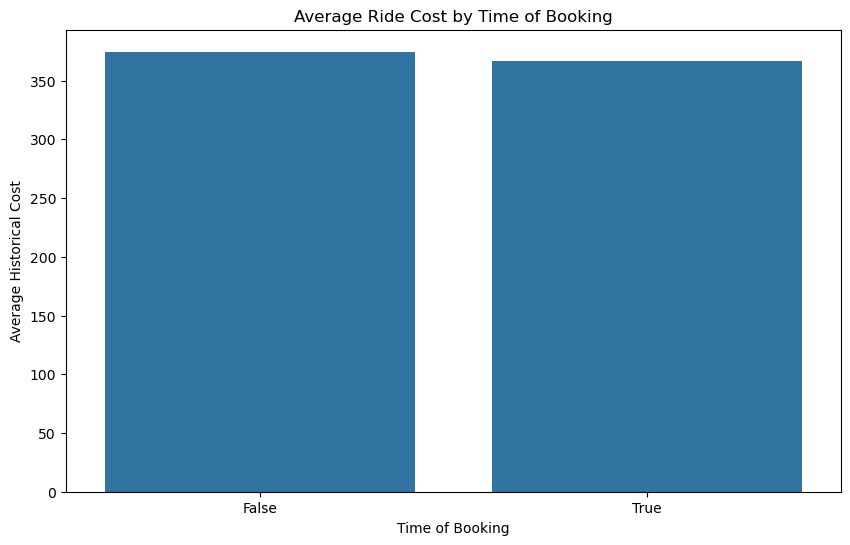

In [19]:
# Average Cost by Time of Booking
plt.figure(figsize=(10, 6))
sns.barplot(x='Time_of_Booking_Night', y='Historical_Cost_of_Ride', data=data, estimator=np.mean, ci=None)
plt.title("Average Ride Cost by Time of Booking")
plt.xlabel("Time of Booking")
plt.ylabel("Average Historical Cost")
plt.show()

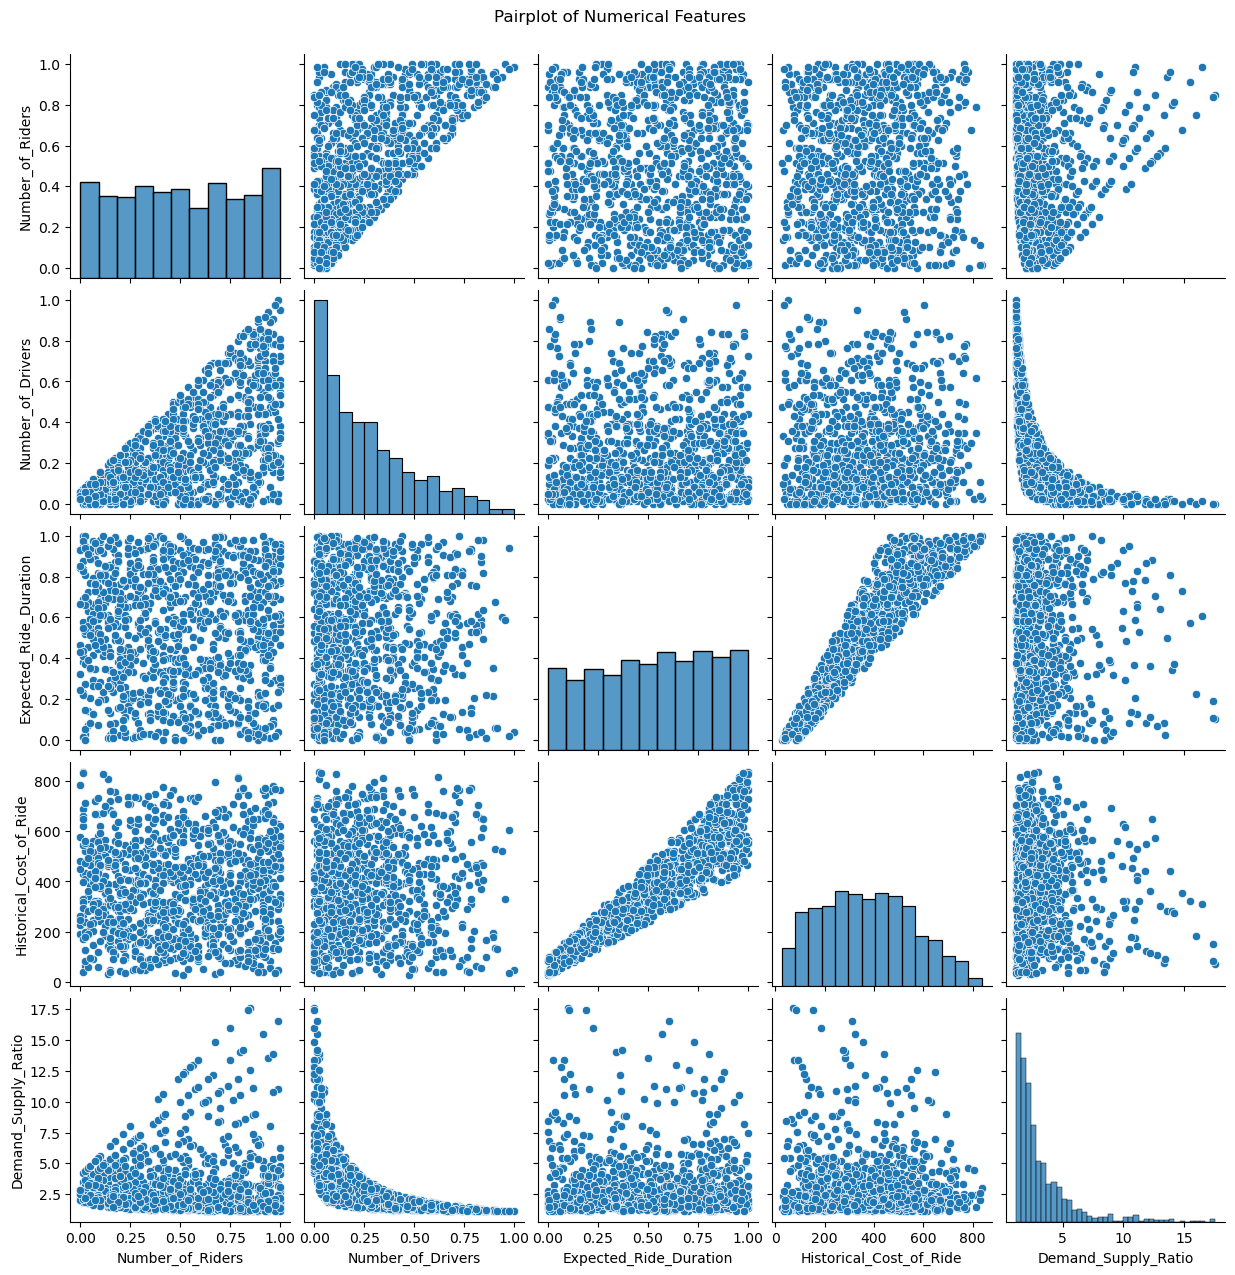

In [20]:
# Pairplot
sns.pairplot(data[['Number_of_Riders', 'Number_of_Drivers', 'Expected_Ride_Duration', 
                   'Historical_Cost_of_Ride', 'Demand_Supply_Ratio']])
plt.suptitle("Pairplot of Numerical Features", y=1.02)
plt.show()


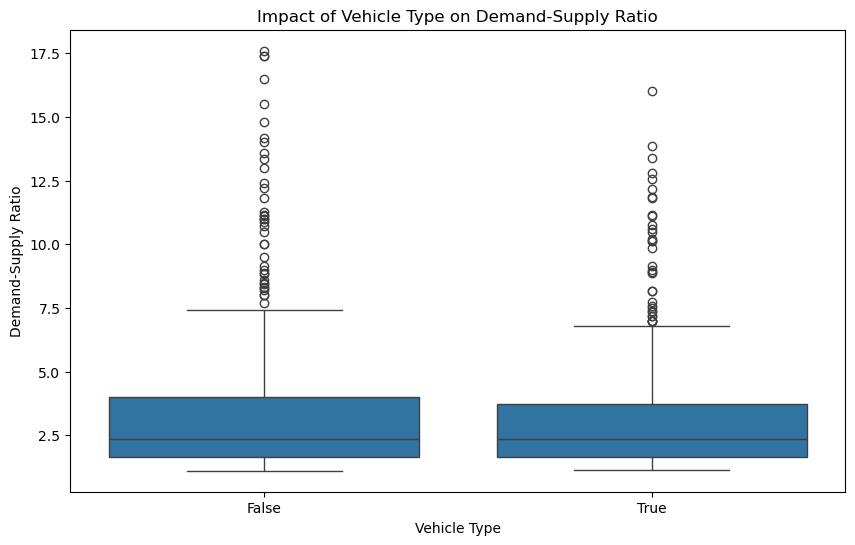

In [21]:
# Vehicle Type vs Demand-Supply Ratio
plt.figure(figsize=(10, 6))
sns.boxplot(x='Vehicle_Type_Premium', y='Demand_Supply_Ratio', data=data)
plt.title("Impact of Vehicle Type on Demand-Supply Ratio")
plt.xlabel("Vehicle Type")
plt.ylabel("Demand-Supply Ratio")
plt.show()


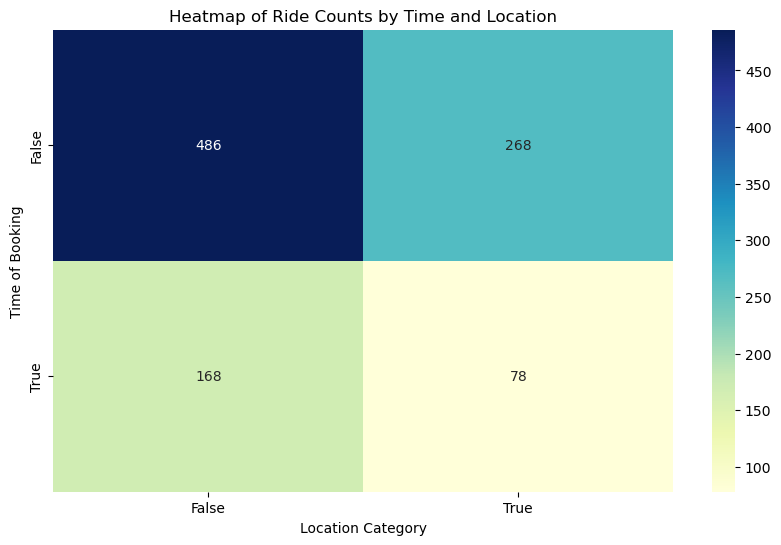

In [22]:
# Pivot table for heatmap
ride_counts = pd.pivot_table(data, values='Historical_Cost_of_Ride', 
                             index='Time_of_Booking_Morning', 
                             columns='Location_Category_Urban', 
                             aggfunc='count', fill_value=0)

plt.figure(figsize=(10, 6))
sns.heatmap(ride_counts, cmap='YlGnBu', annot=True, fmt='d')
plt.title("Heatmap of Ride Counts by Time and Location")
plt.xlabel("Location Category")
plt.ylabel("Time of Booking")
plt.show()

C:\Users\milto\AppData\Local\Temp\ipykernel_14792\1538630911.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_dsr = data.groupby('Time_of_Booking')['Demand_Supply_Ratio'].mean()


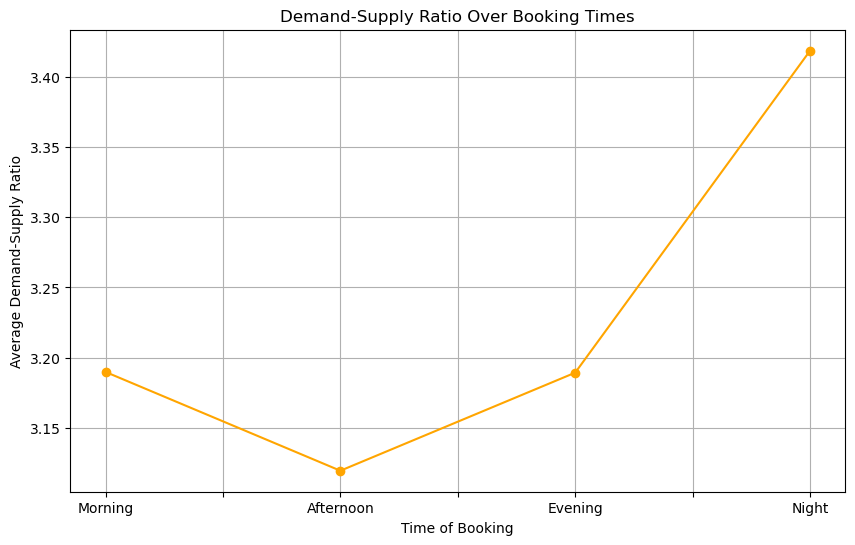

In [25]:
# Line plot for demand-supply ratio

# Reverse one-hot encoding for 'Time_of_Booking'
time_mapping = {
    'Time_of_Booking_Morning': 'Morning',
    'Time_of_Booking_Afternoon': 'Afternoon',
    'Time_of_Booking_Evening': 'Evening',
    'Time_of_Booking_Night': 'Night',
}
data['Time_of_Booking'] = data[[col for col in data.columns if col.startswith('Time_of_Booking')]].idxmax(axis=1).map(time_mapping)

# Ensure the time order is set for the categorical column
time_order = ['Morning', 'Afternoon', 'Evening', 'Night']
data['Time_of_Booking'] = pd.Categorical(data['Time_of_Booking'], categories=time_order, ordered=True)

# Line plot for Demand-Supply Ratio over Booking Times
avg_dsr = data.groupby('Time_of_Booking')['Demand_Supply_Ratio'].mean()

plt.figure(figsize=(10, 6))
avg_dsr.plot(kind='line', marker='o', color='orange')
plt.title("Demand-Supply Ratio Over Booking Times")
plt.xlabel("Time of Booking")
plt.ylabel("Average Demand-Supply Ratio")
plt.grid()
plt.show()


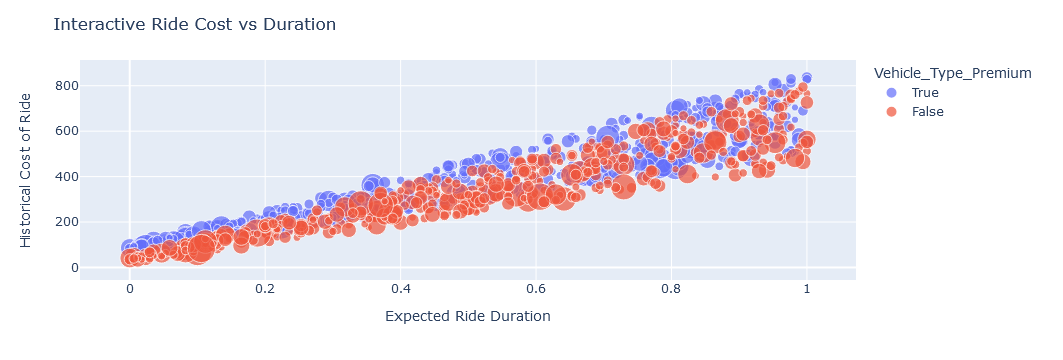

In [27]:
fig = px.scatter(
    data,
    x='Expected_Ride_Duration',
    y='Historical_Cost_of_Ride',
    color='Vehicle_Type_Premium',
    size='Demand_Supply_Ratio',
    hover_data=['Location_Category_Rural', 'Location_Category_Suburban', 'Location_Category_Urban']
)
fig.update_layout(
    title="Interactive Ride Cost vs Duration",
    xaxis_title="Expected Ride Duration",
    yaxis_title="Historical Cost of Ride"
)
fig.show()